# 深度学习与自然语言处理第四次大作业——基于LSTM的文本生成模型

## 19231178 于天贺

## 一、实验目标
基于LSTM（或者Seq2seq）来实现文本生成模型，输入一段已知的金庸小说段落作为提示语，来生成新的段落并做定量与定性的分析。

## 二、实验原理
### LSTM模型

长短期记忆网络（Long Short-Term Memory，LSTM）是一种常用的循环神经网络（Recurrent Neural Network，RNN）架构，用于处理序列数据，特别是具有长期依赖关系的序列数据。

  LSTM通过引入一种称为"门"的机制来解决传统RNN中的梯度消失和梯度爆炸问题，使其能够有效地捕捉和利用长期依赖关系。下面是LSTM的主要组成部分及其工作原理：

  1.输入门（Input Gate）：控制是否将新的输入信息添加到细胞状态中。它通过对输入和前一个时刻的隐藏状态进行加权和，然后经过一个sigmoid函数来生成一个0到1之间的值，表示每个输入元素的重要性。

  2.遗忘门（Forget Gate）：控制前一个时刻的细胞状态中哪些信息被保留下来。它通过对输入和前一个时刻的隐藏状态进行加权和，然后经过一个sigmoid函数来生成一个0到1之间的值，表示每个细胞状态元素的保留程度。

  3.细胞状态更新（Cell State Update）：根据输入门和遗忘门的结果，计算新的候选细胞状态。首先，使用输入门来确定哪些信息将被添加到细胞状态中。然后，使用遗忘门来决定前一个时刻的细胞状态中哪些信息应该被遗忘。最后，将两者结合得到新的细胞状态。

  4.输出门（Output Gate）：根据输入和前一个时刻的隐藏状态来控制当前时刻的输出。它通过对输入和前一个时刻的隐藏状态进行加权和，然后经过一个sigmoid函数来生成一个0到1之间的值，表示每个细胞状态元素对输出的贡献程度。同时，将当前细胞状态通过一个tanh函数进行处理，得到一个介于-1和1之间的值，表示当前时刻的输出。
  
  LSTM的单元结构如下图所示：

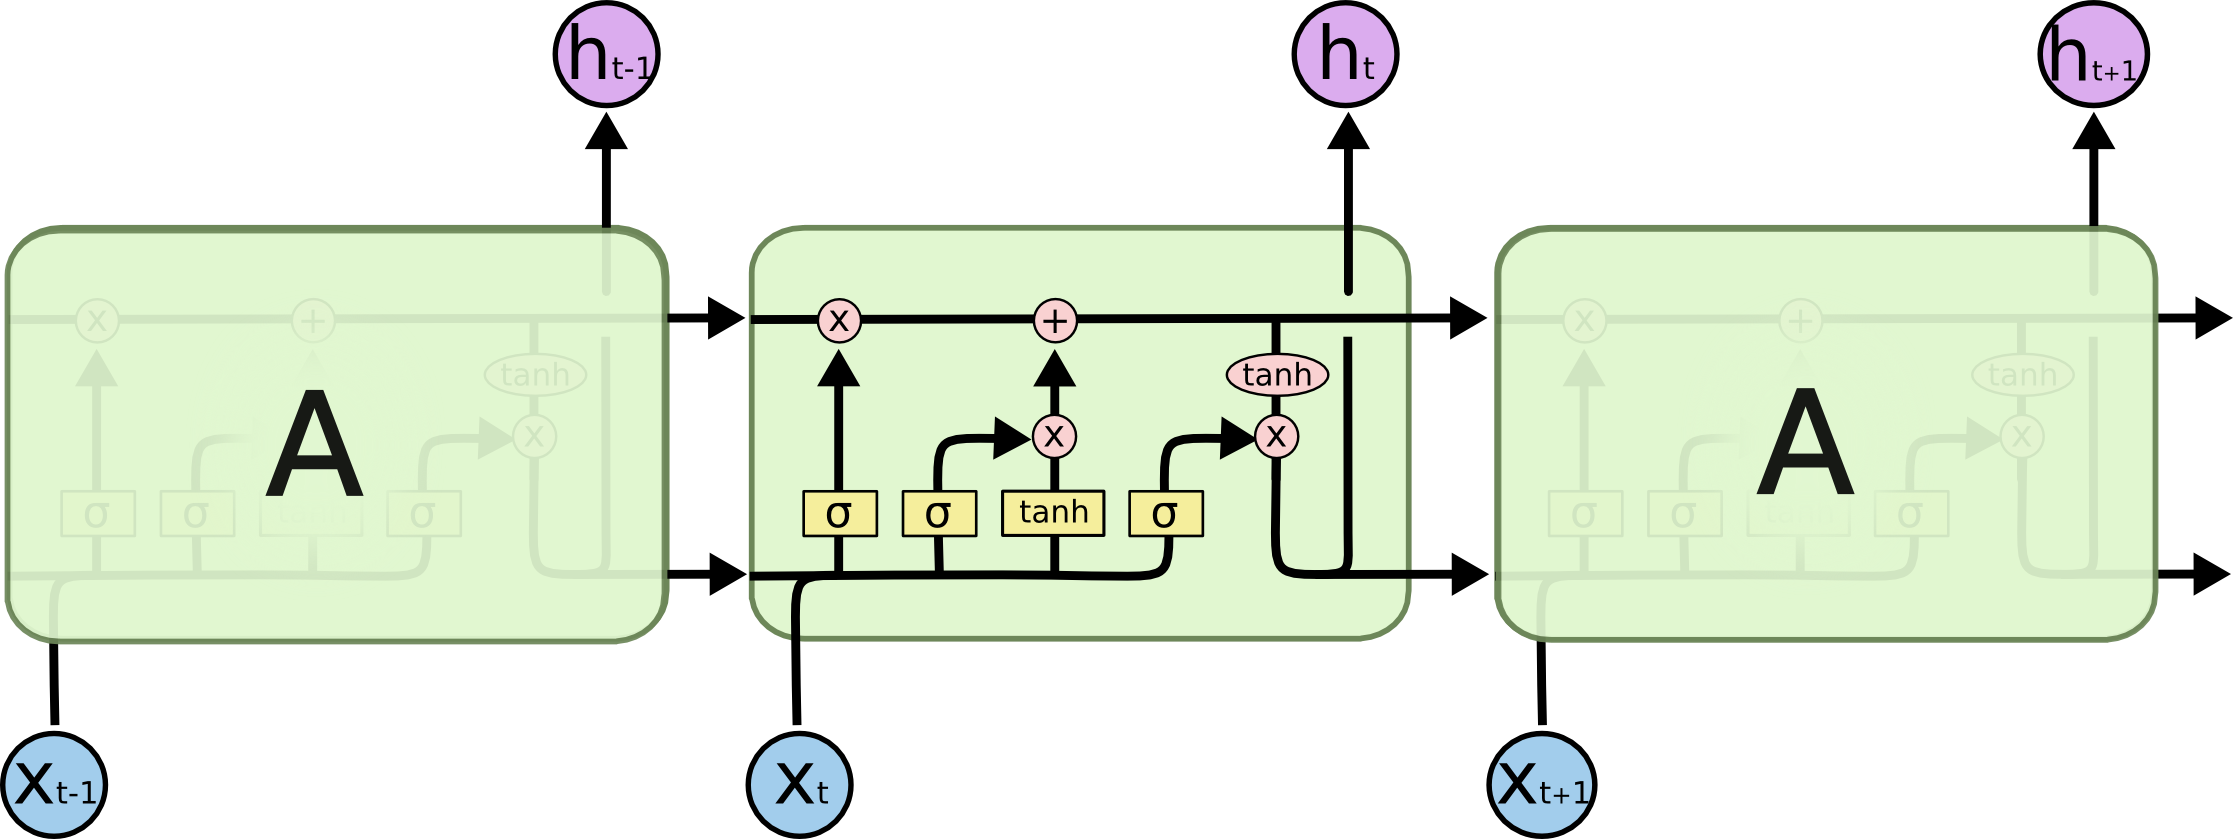

  通过以上步骤，LSTM能够有效地处理序列数据，并在学习过程中保留和利用长期依赖关系。它的主要优点是能够对输入和输出的时间步长没有限制，并且能够捕捉到较长距离的依赖关系。这使得LSTM在诸如语言建模、机器翻译、语音识别等序列数据处理任务中取得了广泛应用。

## 三、实验过程、实验结果与分析

### 导入所需的库
导入代码需要的相关的库，其中jieba用于分词，tqdm用于打印进度条

In [1]:
import jieba
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import random
import re
import time
import numpy as np

### 定义数据读取与预处理的函数
定义读取文章并进行预处理的函数，这里的预处理操作不能像之前预处理一样，将标点符号都去除，因为对于文本生成模型来说，标点符号也在中文文本中具有其存在的意义，可以表示停顿——例如句号和逗号，也可以表示情感——例如问号表示疑问、感叹号表示惊讶，也可以代表说的话——例如双引号和冒号。所以不能随意地删除。

而观察射雕英雄传的文本可以发现，存在许多不属于中文文本中应该有的符号，这些符号是预处理阶段应该删除的，包括回车符、制表符、空格，还有一些乱码，如□。

同时，射雕英雄传里，有些地方的双引号和单引号以「」『』的形式表示，这需要替换成正常中文文本中的双引号和单引号。

同时有些不属于射雕英雄传内容的中文也应该删除。

In [4]:
def read_text(path):
    # root_dir = './jyxstxtqj_downcc.com/'
    # path = os.path.join(root_dir, '射雕英雄传.txt')
    with open(os.path.abspath(path), "r", encoding='ansi') as file:
        file_content = file.read()

    file_content = file_content. \
        replace("本书来自www.cr173.com免费txt小说下载站", '')
    file_content = file_content. \
        replace("更多更新免费电子书请关注www.cr173.com", '')
    file_content = file_content. \
        replace("----〖新语丝电子文库(www.xys.org)〗", '')

    file_content = file_content.replace("\n", '')
    file_content = file_content.replace("\t", '')
    file_content = file_content.replace(" ", '')
    file_content = file_content.replace('\u3000', '')
    file_content = file_content.replace('」', '”')
    file_content = file_content.replace('「', '“')
    file_content = file_content.replace('□', '')
    file_content = file_content.replace('』', '’')
    file_content = file_content.replace('『', '‘')
    # print(type(file_content))
    # print(len(file_content))
    text = list(jieba.cut(file_content))
    print('经过预处理后文章总词数：', len(text))
    return text

### 读取数据并构建映射字典
由于语料库比较庞大，16篇小说如果全部用于训练的话，训练过程过于漫长，于是我只选用射雕英雄传这篇作为语料库。

同时由于LSTM网络不接受中文汉字作为输入，所以需要构建汉字到索引的映射字典，将汉字词语列表转化为索引列表，以供网络进行训练。

由于测试阶段仍需要将网络的输出索引转化为汉字查看模型的文字生成效果，所以还需要构建索引到汉字的映射字典。

In [6]:
word_lst = read_text(path='./jyxstxtqj_downcc.com/射雕英雄传.txt')

# 构建字典映射每个中文字到索引的关系
word2index = {}

for word in word_lst:
    if word not in word2index:
        word2index[word] = len(word2index)

index2word = {index: word for word, index in word2index.items()}

# 将中文转换为索引
index_lst = [word2index[word] for word in word_lst]

经过预处理后文章总词数： 585982


### 定义LSTM模型

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        outputs = self.fc_out(outputs)

        return outputs

### 设置超参数
LSTM模型中嵌入层的定义需要两个参数，一个是语料库字典的词语总数vocab_size，另一个是将语料库每个词语扩充的特征维度embed_size。

LSTM模型中LSTM层的定义需要三个参数，一个是嵌入层将语料库每个词语扩充的特征维度embed_size，一个是LSTM模型的每个时间步的每一个隐藏层的神经元数量hidden_size，另一个是LSTM模型每个时间步的隐藏层层数num_layers。

LSTM模型最后的全连接层，需要将LSTM的输出转化为语料库字典中每个词语的概率，所以输出维度仍为语料库字典的词语总数vocab_size。

对于训练过程，需要设置最大训练周期、批次大小、学习率、LSTM模型接受的句子长度、训练集的范围、是否使用GPU训练、损失函数与优化器。

In [11]:
vocab_size = len(word2index) # 词典中总共的词数
embed_size = 30 # 每个词语嵌入特征数
hidden_size = 512 # LSTM的每个时间步的每一层的神经元数量
num_layers = 2 # LSTM的每个时间步的隐藏层层数

max_epoch = 30
batch_size = 16
learning_rate = 0.001
sentence_len = 20
train_lst = [i for i in range(0,10000)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = LSTM(vocab_size, embed_size, hidden_size, num_layers, vocab_size).to(device)
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 模型训练
LSTM模型的训练需要注意一点，模型的目标输出语序列应该是输入序列的往后一个词语的序列，即每个输入序列向右移动一个位置作为目标序列，这样才能保证经过训练以后的模型可以根据输入依次生成词语。

同时在训练结束后需要保存模型以供测试

In [ ]:
for epoch in tqdm(range(max_epoch)):
    for i in train_lst:  # 打印循环中的进度条
        inputs = torch.tensor([index_lst[j:j+sentence_len] for j in range(i,i+batch_size)]).to(device)
        targets = torch.tensor([index_lst[j+1:j+1+sentence_len] for j in range(i,i+batch_size)]).to(device)
        outputs = model(inputs)

        loss = criterion(outputs.view(outputs.size(0)*outputs.size(1), -1), targets.view(-1))
        model.zero_grad()  # 梯度清零
        loss.backward()  # 反向传播
        optimizer.step()
        
'''保存模型'''
save_path = './trained_model/lstm2.pth'
torch.save(model, save_path)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

### 模型测试
从射雕英雄传里，非训练集部分，寻找10个sentence_len长度的句子，作为测试模型的初始输入，让模型分别依照这10句话进行生成。

测试阶段，设定生成序列长度generate_length，表示测试阶段允许模型生成多少个词

让模型根据初始输入序列，生成新的序列，并取模型输出的序列的最后一个词，存储到generate_lst中，之后让模型根据generate_lst的后sentence_len个词继续作为输入，获得新的输出序列的最后一个词，继续存储到generate_lst中，以此类推，知道生成序列长度达到generate_length结束。

In [13]:
def tensor_to_str(index2word_dict, class_tensor):
    # 将张量转换为字符串
    class_lst = list(class_tensor)
    words = [index2word_dict[int(index)] for index in class_lst]
    
    # 将列表中的词语连接为一个字符串
    sentence = ''.join(words)
    return sentence

In [24]:
test_model = torch.load('./trained_model/lstm2.pth').to('cpu')

generate_length = 100
test_set = [index_lst[i:i+sentence_len] for i in range(20000, 30000, 1000)]
target_set = [index_lst[i:i+sentence_len+generate_length] for i in range(20000, 30000, 1000)]


for i in range(0, len(test_set)):
    generate_lst = []
    generate_lst.extend(test_set[i])
    for j in range(0, generate_length):
        inputs = torch.tensor(generate_lst[-sentence_len:]) # 选取生成词语列表的最后sentence_len个元素作为下一次模型的输入
        outputs = test_model(inputs)

        predicted_class = torch.argmax(outputs, dim=-1)
        
        generate_lst.append(int(predicted_class[-1]))

    input_sentence = tensor_to_str(index2word, test_set[i])
    generate_sentence = tensor_to_str(index2word, generate_lst)
    target_sentence = tensor_to_str(index2word, target_set[i])
    # 打印生成结果
    print('测试结果', i)
    print()
    print('初始输入句：\n',input_sentence)
    print()
    print('模型生成句：\n',generate_sentence)
    print()
    print('期待生成句：\n',target_sentence)
    print()
    print('='*50)

测试结果 0

初始输入句：
 ，但见那乘马奔到大街转弯角处，忽然站住。完颜洪烈又是一奇，心想马匹

模型生成句：
 ，但见那乘马奔到大街转弯角处，忽然站住。完颜洪烈又是一奇，心想马匹，就留给两个还没出世，忽然转念：“别鬼使神差的，偏偏有人这时过来撞见。”鼓起勇气，过去拉那尸首，想拉入草丛之中藏起，再去叫丈夫。不料她伸手一拉，那尸首又呻吟了一下，声音甚是微弱。她才知此人未死。定睛看时，见他背后肩头中了一枝狼牙利箭，深入肉里，箭枝上染满了血污。天空雪花兀自不断飘下，那人全身已罩上了薄薄一层白雪，

期待生成句：
 ，但见那乘马奔到大街转弯角处，忽然站住。完颜洪烈又是一奇，心想马匹疾驰，必须逐渐放慢脚步方能停止，此马竟能在急行之际斗然收步，实是前所未睹，就算是武功高明之人，也未必能在发力狂奔之时如此神定气闲的蓦地站定。只见那矮胖子飞身下马，钻入一家店内。完颜洪烈快步走将过去，只见店中直立着一块大木牌，写着“太白遗风”四字，却是一家酒楼，再抬头看时，楼头一块极大的金字招牌，写着“醉仙楼”三个大字

测试结果 1

初始输入句：
 。那人腰里插了一柄砍柴用的短斧，斧刃上有几个缺口。两人刚

模型生成句：
 。那人腰里插了一柄砍柴用的短斧，斧刃上有几个缺口。两人刚笑道：“说不定！”这时了五年龙廷，那人全身已罩上了薄薄一层白雪，只须过得半夜，便冻也冻死了。她自幼便心地仁慈，只要见到受了伤的麻雀、田鸡、甚至虫豸蚂蚁之类，必定带回家来妥为喂养，直到伤愈，再放回田野，若是医治不好，就会整天不乐，这脾气大了仍旧不改，以致屋子里养满了诸般虫蚁、小禽小兽。她父亲是个屡试不第的村

期待生成句：
 。那人腰里插了一柄砍柴用的短斧，斧刃上有几个缺口。两人刚坐定，楼下脚步声响，上来两人。那渔女叫道：“五哥、六哥，你们一齐来啦。”前面一人身材魁梧，少说也有二百五六十斤，围着一条长围裙，全身油腻，敞开衣襟，露出毛茸茸的胸膛，袖子卷得高高的，手臂上全是寸许长的黑毛，腰间皮带上插着柄尺来长的尖刀，瞧模样是个杀猪宰羊的屠夫。后面那人五短身材，头戴小毡帽，白净面皮，手里提了一杆秤，

测试结果 2

初始输入句：
 查觉，当即带同亲随，由临安府的捕快衙役领路，亲自追拿刺客。追

模型生成句：
 查觉，当即带同亲随，由临安府的捕快衙役领路，亲自追拿刺客。追她，只听在断墙残瓦的破败之地，直到人挟持，当下捡出丈夫

### 实验结果分析
<p style="color: red; font-size: 16px; line-height: 2;">观察几个测试结果，可以发现，生成的语句具有逻辑性，比较连贯，人可以读懂，标点符号的使用也比较正确。同时生成语句中的人物，语言风格，也符合射雕英雄传中的内容。将生成语句与真实的原文句子对比，可以发现，内容对比上还是有一定差距。
</p>

### 可以改进的地方
由于算力与时间的限制，我选择的训练集只有射雕英雄传的10000个长度为20的序列，在时间和算力充足的条件下数据集的规模可以进一步提升，这样经过训练的模型语句生成能力会更好。

同时网络结构方面，为了节省算力与训练时间，我设置的LSTM模型网络比较简单，每个词语的嵌入特征数只有30，LSTM的每一隐藏层的神经元只有512，且每个时间步的隐藏层层数只有2层，这些在时间与算力充足的条件下都可以进一步增加。